In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
fig_folder = 'D:\\projects_q_30_10_2024\\isttc\\results\\monkey\\fig_drafts\\'

### Get the data

In [4]:
results_folder = 'D:\\projects_q_30_10_2024\\isttc\\results\\monkey\\fixation_period_1000ms\\'

pfdl_acf_average_trial_pearsonr_df = pd.read_pickle(results_folder + 'binned\\pfdl\\acf\\' + 'acf_average_trial_pearsonr_50ms_20lags_df.pkl')
pfp_acf_average_trial_pearsonr_df = pd.read_pickle(results_folder + 'binned\\pfp\\acf\\' + 'acf_average_trial_pearsonr_50ms_20lags_df.pkl')

pfdl_acf_average_trial_sttc_df = pd.read_pickle(results_folder + 'non_binned\\pfdl\\acf\\' + 'acf_average_trial_sttc_50ms_20lags_df.pkl')
pfp_acf_average_trial_sttc_df = pd.read_pickle(results_folder + 'non_binned\\pfp\\acf\\' + 'acf_average_trial_sttc_50ms_20lags_df.pkl')

print('N neurons in PFdl {} \nN neurons in PFp {}'.format(len(pfdl_acf_average_trial_pearsonr_df), len(pfp_acf_average_trial_pearsonr_df)))
print('N neurons in PFdl {} \nN neurons in PFp {}'.format(len(pfdl_acf_average_trial_sttc_df), len(pfp_acf_average_trial_sttc_df)))

print('NaNs in PFdl acf {}'.format(pfdl_acf_average_trial_pearsonr_df.isnull().any().any()))
print('NaNs in PFp acf {}'.format(pfp_acf_average_trial_pearsonr_df.isnull().any().any()))

print('NaNs in PFdl acf {}'.format(pfdl_acf_average_trial_sttc_df.isnull().any().any()))
print('NaNs in PFp acf {}'.format(pfp_acf_average_trial_sttc_df.isnull().any().any()))

N neurons in PFdl 541 
N neurons in PFp 541
N neurons in PFdl 541 
N neurons in PFp 541
NaNs in PFdl acf True
NaNs in PFp acf True
NaNs in PFdl acf False
NaNs in PFp acf False


In [5]:
pfdl_acf_average_trial_sttc_df.head(2)

,unit_id,acf_0,acf_1,acf_2,acf_3,acf_4,acf_5,acf_6,acf_7,acf_8,...,acf_10,acf_11,acf_12,acf_13,acf_14,acf_15,acf_16,acf_17,acf_18,acf_19
0,0,1.0,0.559754,0.515696,0.502268,0.482715,0.449641,0.427961,0.404055,0.42711,...,0.403228,0.371616,0.418338,0.383152,0.388130,0.381526,0.335855,0.340939,0.316042,0.353275
1,1,1.0,0.033248,0.067109,0.020204,0.035725,0.068136,0.048423,0.135304,-0.01916,...,-0.017298,0.051934,-0.015382,0.043499,0.088318,-0.015124,-0.012707,-0.009642,-0.008264,0.000000


In [9]:
# load taus

pfdl_tau_pearsonr_df = pd.read_pickle(results_folder + 'binned\\pfdl\\taus\\' + 'tau_acf_average_trial_pearsonr_df_50ms_20lags_df.pkl')
pfp_tau_pearsonr_df = pd.read_pickle(results_folder + 'binned\\pfp\\taus\\' + 'tau_acf_average_trial_pearsonr_df_50ms_20lags_df.pkl')

pfdl_tau_sttc_df = pd.read_pickle(results_folder + 'non_binned\\pfdl\\taus\\' + 'tau_acf_average_trial_sttc_df_50ms_20lags_df.pkl')
pfp_tau_sttc_df = pd.read_pickle(results_folder + 'non_binned\\pfp\\taus\\' + 'tau_acf_average_trial_sttc_df_50ms_20lags_df.pkl')

print('N neurons in PFdl {} \nN neurons in PFp {}'.format(len(pfdl_tau_pearsonr_df), len(pfp_tau_pearsonr_df)))
print('N neurons in PFdl {} \nN neurons in PFp {}'.format(len(pfdl_tau_sttc_df), len(pfp_tau_sttc_df)))

N neurons in PFdl 541 
N neurons in PFp 541
N neurons in PFdl 541 
N neurons in PFp 541


In [10]:
pfdl_tau_acf_pearsonr_df = pfdl_acf_average_trial_pearsonr_df.merge(pfdl_tau_pearsonr_df, on='unit_id', how='left')
pfp_tau_acf_pearsonr_df = pfp_acf_average_trial_pearsonr_df.merge(pfp_tau_pearsonr_df, on='unit_id', how='left')

pfdl_tau_acf_sttc_df = pfdl_acf_average_trial_sttc_df.merge(pfdl_tau_sttc_df, on='unit_id', how='left')
pfp_tau_acf_sttc_df = pfp_acf_average_trial_sttc_df.merge(pfp_tau_sttc_df, on='unit_id', how='left')

In [11]:
pfp_tau_acf_sttc_df.head(2)

,unit_id,acf_0,acf_1,acf_2,acf_3,acf_4,acf_5,acf_6,acf_7,acf_8,...,acf_16,acf_17,acf_18,acf_19,fit_a,fit_b,fit_c,tau,r_squared,tau_ms
0,0,1.0,0.149503,0.090789,0.107328,0.142620,0.069971,0.040691,0.019864,0.044535,...,0.092043,0.015594,0.023097,-0.027668,0.141099,0.265407,0.035975,3.767804,0.473074,188.390196
1,1,1.0,0.074197,0.201763,0.042812,0.067938,0.013455,0.147597,0.058625,0.112259,...,0.000000,-0.014694,0.000000,0.000000,3.696751,0.002055,-3.576034,486.646353,0.456805,24332.317652


### Calc ACF and tau constraints

1. ACF decline within 150-250ms
2. tau > 0

In [12]:
acf_cols = ['acf_' + str(i) for i in range(20)]

In [13]:
def calculate_acf_decline_flag(acf_2d, start_idx=3, end_idx=5):
    decay_l = []
    for i in range(acf_2d.shape[0]):
        decay_l.append(np.all(np.diff(acf_2d[i, start_idx:end_idx]) <= 0))
    return decay_l

In [14]:
pfdl_pearsonr_2d = pfdl_tau_acf_pearsonr_df[acf_cols].values
pfdl_pearsonr_2d_acf_decay = calculate_acf_decline_flag(pfdl_pearsonr_2d, start_idx=3, end_idx=5)

pfdl_tau_acf_pearsonr_df.insert(1, 'decline_150_250', pfdl_pearsonr_2d_acf_decay)
pfdl_tau_acf_pearsonr_df.head(2)

,unit_id,decline_150_250,acf_0,acf_1,acf_2,acf_3,acf_4,acf_5,acf_6,acf_7,...,acf_16,acf_17,acf_18,acf_19,fit_a,fit_b,fit_c,tau,r_squared,tau_ms
0,0,True,1.0,0.443787,0.429808,0.374760,0.333984,0.287734,0.240484,0.189922,...,0.020760,0.038556,0.046108,-0.052432,0.744809,0.049136,-0.277458,20.35156,0.915422,1017.578017
1,1,False,1.0,0.005432,0.069626,-0.009532,0.027993,0.051967,0.029365,0.119701,...,-0.040645,-0.040116,-0.044426,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
pfp_pearsonr_2d = pfp_tau_acf_pearsonr_df[acf_cols].values
pfp_pearsonr_2d_acf_decay = calculate_acf_decline_flag(pfp_pearsonr_2d, start_idx=3, end_idx=5)

pfp_tau_acf_pearsonr_df.insert(1, 'decline_150_250', pfp_pearsonr_2d_acf_decay)
pfp_tau_acf_pearsonr_df.head(2)

,unit_id,decline_150_250,acf_0,acf_1,acf_2,acf_3,acf_4,acf_5,acf_6,acf_7,...,acf_16,acf_17,acf_18,acf_19,fit_a,fit_b,fit_c,tau,r_squared,tau_ms
0,0,False,1.0,0.119814,0.063838,0.059544,0.111271,0.030454,-0.016651,0.004328,...,0.046246,-0.044815,0.083069,-0.100631,0.174112,0.303765,-0.00923,3.292019,0.399825,164.600967
1,1,False,1.0,0.025840,0.196101,0.048704,0.065994,-0.014372,0.156284,0.010443,...,NaN,-0.125656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
pfdl_sttc_2d = pfdl_tau_acf_sttc_df[acf_cols].values
pfdl_sttc_2d_acf_decay = calculate_acf_decline_flag(pfdl_sttc_2d, start_idx=3, end_idx=5)

pfdl_tau_acf_sttc_df.insert(1, 'decline_150_250', pfdl_sttc_2d_acf_decay)
pfdl_tau_acf_sttc_df.head(2)

,unit_id,decline_150_250,acf_0,acf_1,acf_2,acf_3,acf_4,acf_5,acf_6,acf_7,...,acf_16,acf_17,acf_18,acf_19,fit_a,fit_b,fit_c,tau,r_squared,tau_ms
0,0,True,1.0,0.559754,0.515696,0.502268,0.482715,0.449641,0.427961,0.404055,...,0.335855,0.340939,0.316042,0.353275,0.257802,0.123009,0.320457,8.12948,0.923040,4.064740e+02
1,1,False,1.0,0.033248,0.067109,0.020204,0.035725,0.068136,0.048423,0.135304,...,-0.012707,-0.009642,-0.008264,0.000000,76.091455,0.000043,-76.033765,23347.82903,0.174076,1.167391e+06


In [17]:
pfp_sttc_2d = pfp_tau_acf_sttc_df[acf_cols].values
pfp_sttc_2d_acf_decay = calculate_acf_decline_flag(pfp_sttc_2d, start_idx=3, end_idx=5)

pfp_tau_acf_sttc_df.insert(1, 'decline_150_250', pfp_sttc_2d_acf_decay)
pfp_tau_acf_sttc_df.head(2)

,unit_id,decline_150_250,acf_0,acf_1,acf_2,acf_3,acf_4,acf_5,acf_6,acf_7,...,acf_16,acf_17,acf_18,acf_19,fit_a,fit_b,fit_c,tau,r_squared,tau_ms
0,0,False,1.0,0.149503,0.090789,0.107328,0.142620,0.069971,0.040691,0.019864,...,0.092043,0.015594,0.023097,-0.027668,0.141099,0.265407,0.035975,3.767804,0.473074,188.390196
1,1,False,1.0,0.074197,0.201763,0.042812,0.067938,0.013455,0.147597,0.058625,...,0.000000,-0.014694,0.000000,0.000000,3.696751,0.002055,-3.576034,486.646353,0.456805,24332.317652


In [18]:
# tau > 0
pfp_tau_acf_sttc_df['tau_more_0'] = pfp_tau_acf_sttc_df['tau_ms'] > 0
pfdl_tau_acf_sttc_df['tau_more_0'] = pfdl_tau_acf_sttc_df['tau_ms'] > 0
pfp_tau_acf_pearsonr_df['tau_more_0'] = pfp_tau_acf_pearsonr_df['tau_ms'] > 0
pfdl_tau_acf_pearsonr_df['tau_more_0'] = pfdl_tau_acf_pearsonr_df['tau_ms'] > 0

In [ ]:
pfp_tau_acf_sttc_df

In [19]:
# subsets for merging

pfdl_tau_acf_pearsonr_df_subset = pfdl_tau_acf_pearsonr_df[['unit_id', 'decline_150_250', 'tau_ms', 'r_squared', 'tau_more_0']].copy()
pfdl_tau_acf_sttc_df_subset = pfdl_tau_acf_sttc_df[['unit_id', 'decline_150_250', 'tau_ms', 'r_squared', 'tau_more_0']].copy()

pfdl_tau_acf_df_merged = pfdl_tau_acf_pearsonr_df_subset.merge(pfdl_tau_acf_sttc_df_subset, on='unit_id', how='left', suffixes=('_pear', '_sttc'))
pfdl_tau_acf_df_merged['diff'] = pfdl_tau_acf_df_merged['r_squared_sttc'] - pfdl_tau_acf_df_merged['r_squared_pear']
pfdl_tau_acf_df_merged['area'] = 'pfdl'
pfdl_tau_acf_df_merged

,unit_id,decline_150_250_pear,tau_ms_pear,r_squared_pear,tau_more_0_pear,decline_150_250_sttc,tau_ms_sttc,r_squared_sttc,tau_more_0_sttc,diff,area
0,0,True,1017.578017,0.915422,True,True,4.064740e+02,0.923040,True,0.007618,pfdl
1,1,False,NaN,NaN,False,False,1.167391e+06,0.174076,True,NaN,pfdl
2,2,True,46.285986,0.018274,True,True,5.181487e+02,0.036338,True,0.018063,pfdl
3,3,True,303.422372,0.902445,True,True,3.360255e+02,0.832371,True,-0.070074,pfdl
4,4,True,173.862634,0.682101,True,True,2.347666e+02,0.353825,True,-0.328276,pfdl
...,...,...,...,...,...,...,...,...,...,...,...
536,539,True,388.408865,0.454283,True,True,1.399955e+02,0.186251,True,-0.268033,pfdl
537,540,True,105.797758,0.841620,True,True,1.317279e+02,0.832988,True,-0.008632,pfdl
538,541,True,107.580378,0.936433,True,True,-4.056407e+06,0.507698,False,-0.428735,pfdl
539,542,True,153.329740,0.662705,True,True,1.814797e+02,0.726655,True,0.063950,pfdl


In [20]:
pfp_tau_acf_pearsonr_df_subset = pfp_tau_acf_pearsonr_df[['unit_id', 'decline_150_250', 'tau_ms', 'r_squared', 'tau_more_0']].copy()
pfp_tau_acf_sttc_df_subset = pfp_tau_acf_sttc_df[['unit_id', 'decline_150_250', 'tau_ms', 'r_squared', 'tau_more_0']].copy()

pfp_tau_acf_df_merged = pfp_tau_acf_pearsonr_df_subset.merge(pfp_tau_acf_sttc_df_subset, on='unit_id', how='left', suffixes=('_pear', '_sttc'))
pfp_tau_acf_df_merged['diff'] = pfp_tau_acf_df_merged['r_squared_sttc'] - pfp_tau_acf_df_merged['r_squared_pear']
pfp_tau_acf_df_merged['area'] = 'pfp'
pfp_tau_acf_df_merged

,unit_id,decline_150_250_pear,tau_ms_pear,r_squared_pear,tau_more_0_pear,decline_150_250_sttc,tau_ms_sttc,r_squared_sttc,tau_more_0_sttc,diff,area
0,0,False,164.600967,0.399825,True,False,188.390196,0.473074,True,0.073249,pfp
1,1,False,NaN,NaN,False,False,24332.317652,0.456805,True,NaN,pfp
2,2,False,NaN,NaN,False,False,15995.421778,0.753588,True,NaN,pfp
3,3,False,NaN,NaN,False,False,504.766035,0.616143,True,NaN,pfp
4,4,False,44.725763,0.332874,True,False,40.725301,0.343808,True,0.010934,pfp
...,...,...,...,...,...,...,...,...,...,...,...
536,538,False,NaN,NaN,False,False,4.978634,0.018874,True,NaN,pfp
537,539,True,NaN,NaN,False,True,356.311558,0.631718,True,NaN,pfp
538,540,True,NaN,NaN,False,True,107.370092,0.009953,True,NaN,pfp
539,541,True,49.872242,0.385906,True,False,26.615452,0.206875,True,-0.179032,pfp


In [21]:
tau_acf_df_merged = pd.concat([pfdl_tau_acf_df_merged, pfp_tau_acf_df_merged])
tau_acf_df_merged.reset_index(inplace=True, drop=True)
tau_acf_df_merged

,unit_id,decline_150_250_pear,tau_ms_pear,r_squared_pear,tau_more_0_pear,decline_150_250_sttc,tau_ms_sttc,r_squared_sttc,tau_more_0_sttc,diff,area
0,0,True,1017.578017,0.915422,True,True,4.064740e+02,0.923040,True,0.007618,pfdl
1,1,False,NaN,NaN,False,False,1.167391e+06,0.174076,True,NaN,pfdl
2,2,True,46.285986,0.018274,True,True,5.181487e+02,0.036338,True,0.018063,pfdl
3,3,True,303.422372,0.902445,True,True,3.360255e+02,0.832371,True,-0.070074,pfdl
4,4,True,173.862634,0.682101,True,True,2.347666e+02,0.353825,True,-0.328276,pfdl
...,...,...,...,...,...,...,...,...,...,...,...
1077,538,False,NaN,NaN,False,False,4.978634e+00,0.018874,True,NaN,pfp
1078,539,True,NaN,NaN,False,True,3.563116e+02,0.631718,True,NaN,pfp
1079,540,True,NaN,NaN,False,True,1.073701e+02,0.009953,True,NaN,pfp
1080,541,True,49.872242,0.385906,True,False,2.661545e+01,0.206875,True,-0.179032,pfp


In [38]:
# NaN counts
pear_nan = tau_acf_df_merged['r_squared_pear'].isna().sum()
sttc_nan = tau_acf_df_merged['r_squared_sttc'].isna().sum()

print(tau_acf_df_merged['r_squared_pear'].isna().sum())
print(tau_acf_df_merged['r_squared_sttc'].isna().sum())

179
1


In [37]:
pfdl_tau_acf_pearsonr_df_subset_long = pfdl_tau_acf_pearsonr_df_subset.copy()
pfdl_tau_acf_pearsonr_df_subset_long['metric'] = 'pear'
pfdl_tau_acf_pearsonr_df_subset_long['area'] = 'pfdl'
pfdl_p_nan = pfdl_tau_acf_pearsonr_df_subset_long['tau_ms'].isna().sum()
print(pfdl_p_nan)

pfp_tau_acf_pearsonr_df_subset_long = pfp_tau_acf_pearsonr_df_subset.copy()
pfp_tau_acf_pearsonr_df_subset_long['metric'] = 'pear'
pfp_tau_acf_pearsonr_df_subset_long['area'] = 'pfp'
pfp_p_nan = pfp_tau_acf_pearsonr_df_subset_long['tau_ms'].isna().sum()
print(pfp_p_nan)

pfdl_tau_acf_sttc_df_subset_long = pfdl_tau_acf_sttc_df_subset.copy()
pfdl_tau_acf_sttc_df_subset_long['metric'] = 'sttc'
pfdl_tau_acf_sttc_df_subset_long['area'] = 'pfdl'
pfdl_s_nan = pfdl_tau_acf_sttc_df_subset_long['tau_ms'].isna().sum()
print(pfdl_s_nan)

pfp_tau_acf_sttc_df_subset_long = pfp_tau_acf_sttc_df_subset.copy()
pfp_tau_acf_sttc_df_subset_long['metric'] = 'sttc'
pfp_tau_acf_sttc_df_subset_long['area'] = 'pfp'
pfp_s_nan = pfp_tau_acf_sttc_df_subset_long['tau_ms'].isna().sum()
print(pfp_s_nan)

tau_df_long = pd.concat([pfdl_tau_acf_pearsonr_df_subset_long, pfp_tau_acf_pearsonr_df_subset_long, 
                         pfdl_tau_acf_sttc_df_subset_long, pfp_tau_acf_sttc_df_subset_long])
tau_df_long.reset_index(inplace=True, drop=True)
tau_df_long

81
98
1
0


,unit_id,decline_150_250,tau_ms,r_squared,tau_more_0,metric,area
0,0,True,1017.578017,0.915422,True,pear,pfdl
1,1,False,NaN,NaN,False,pear,pfdl
2,2,True,46.285986,0.018274,True,pear,pfdl
3,3,True,303.422372,0.902445,True,pear,pfdl
4,4,True,173.862634,0.682101,True,pear,pfdl
...,...,...,...,...,...,...,...
2159,538,False,4.978634,0.018874,True,sttc,pfp
2160,539,True,356.311558,0.631718,True,sttc,pfp
2161,540,True,107.370092,0.009953,True,sttc,pfp
2162,541,False,26.615452,0.206875,True,sttc,pfp


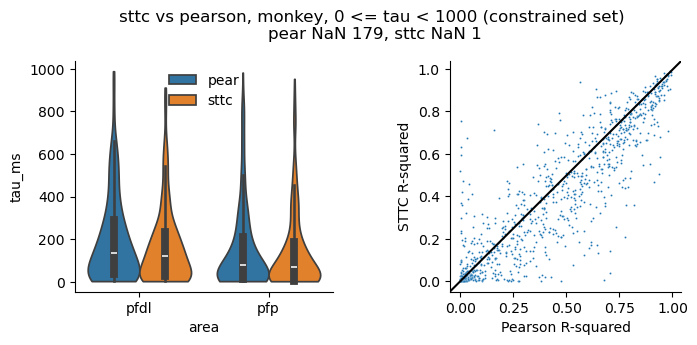

In [40]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.violinplot(ax=axes[0], x='area', y='tau_ms', hue='metric', data=tau_df_long.query('tau_ms >= 0 and tau_ms < 1000'), 
               cut=0, density_norm='width')
axes[0].legend(frameon=False, loc='upper center')

sns.scatterplot(ax=axes[1], x=tau_acf_df_merged['r_squared_pear'].values, y=tau_acf_df_merged['r_squared_sttc'].values, s=2)
axes[1].plot([0, 1], [0, 1], c='k', transform=axes[1].transAxes)
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_xlabel('Pearson R-squared')
axes[1].set_ylabel('STTC R-squared')
#axes[1].set_title('scatter')

fig.suptitle('sttc vs pearson, monkey, 0 <= tau < 1000 (constrained set) \npear NaN ' + str(pear_nan) + ', sttc NaN ' + str(sttc_nan), y=1.05)

sns.despine()

fig.savefig(fig_folder + 'sttc_vs_pearson_full_dataset.png' , bbox_inches='tight')

In [36]:
tau_acf_df_merged[tau_acf_df_merged['r_squared_pear'].isna()]

,unit_id,decline_150_250_pear,tau_ms_pear,r_squared_pear,tau_more_0_pear,decline_150_250_sttc,tau_ms_sttc,r_squared_sttc,tau_more_0_sttc,diff,area
1,1,False,NaN,NaN,False,False,1.167391e+06,0.174076,True,NaN,pfdl
24,24,False,NaN,NaN,False,False,2.200511e+02,0.735460,True,NaN,pfdl
25,25,True,NaN,NaN,False,True,1.007901e+03,0.528229,True,NaN,pfdl
28,28,False,NaN,NaN,False,False,1.693963e+02,0.394957,True,NaN,pfdl
47,47,True,NaN,NaN,False,True,3.023257e+01,0.008695,True,NaN,pfdl
...,...,...,...,...,...,...,...,...,...,...,...
1049,510,True,NaN,NaN,False,True,2.860973e+01,0.011059,True,NaN,pfp
1073,534,True,NaN,NaN,False,True,4.431063e+00,0.039640,True,NaN,pfp
1077,538,False,NaN,NaN,False,False,4.978634e+00,0.018874,True,NaN,pfp
1078,539,True,NaN,NaN,False,True,3.563116e+02,0.631718,True,NaN,pfp


In [23]:
tau_acf_df_merged.dropna()

,unit_id,decline_150_250_pear,tau_ms_pear,r_squared_pear,tau_more_0_pear,decline_150_250_sttc,tau_ms_sttc,r_squared_sttc,tau_more_0_sttc,diff,area
0,0,True,1.017578e+03,0.915422,True,True,4.064740e+02,0.923040,True,0.007618,pfdl
2,2,True,4.628599e+01,0.018274,True,True,5.181487e+02,0.036338,True,0.018063,pfdl
3,3,True,3.034224e+02,0.902445,True,True,3.360255e+02,0.832371,True,-0.070074,pfdl
4,4,True,1.738626e+02,0.682101,True,True,2.347666e+02,0.353825,True,-0.328276,pfdl
5,5,True,4.414734e+02,0.976189,True,True,4.800200e+02,0.977905,True,0.001716,pfdl
...,...,...,...,...,...,...,...,...,...,...,...
1074,535,False,1.158115e+06,0.779180,True,False,1.301002e+06,0.720311,True,-0.058869,pfp
1075,536,True,6.818200e+01,0.819945,True,True,1.058588e+02,0.809262,True,-0.010683,pfp
1076,537,True,8.943022e+01,0.829613,True,True,8.401635e+01,0.798872,True,-0.030741,pfp
1080,541,True,4.987224e+01,0.385906,True,False,2.661545e+01,0.206875,True,-0.179032,pfp


### Plots

In [26]:
tau_acf_df_merged_no_nans = tau_acf_df_merged.dropna()
tau_acf_df_merged_no_nans

,unit_id,decline_150_250_pear,tau_ms_pear,r_squared_pear,tau_more_0_pear,decline_150_250_sttc,tau_ms_sttc,r_squared_sttc,tau_more_0_sttc,diff,area
0,0,True,1.017578e+03,0.915422,True,True,4.064740e+02,0.923040,True,0.007618,pfdl
2,2,True,4.628599e+01,0.018274,True,True,5.181487e+02,0.036338,True,0.018063,pfdl
3,3,True,3.034224e+02,0.902445,True,True,3.360255e+02,0.832371,True,-0.070074,pfdl
4,4,True,1.738626e+02,0.682101,True,True,2.347666e+02,0.353825,True,-0.328276,pfdl
5,5,True,4.414734e+02,0.976189,True,True,4.800200e+02,0.977905,True,0.001716,pfdl
...,...,...,...,...,...,...,...,...,...,...,...
1074,535,False,1.158115e+06,0.779180,True,False,1.301002e+06,0.720311,True,-0.058869,pfp
1075,536,True,6.818200e+01,0.819945,True,True,1.058588e+02,0.809262,True,-0.010683,pfp
1076,537,True,8.943022e+01,0.829613,True,True,8.401635e+01,0.798872,True,-0.030741,pfp
1080,541,True,4.987224e+01,0.385906,True,False,2.661545e+01,0.206875,True,-0.179032,pfp


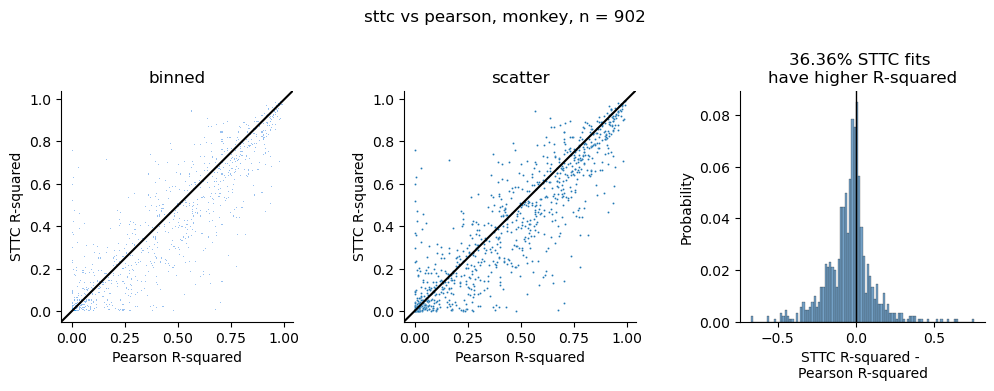

In [27]:
n_sttc_better = len(tau_acf_df_merged_no_nans.query('diff > 0'))
n_sttc_better_perc = n_sttc_better / len(tau_acf_df_merged_no_nans) * 100

fig, axes = plt.subplots(1,3, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.histplot(ax=axes[0], x=tau_acf_df_merged_no_nans['r_squared_pear'].values, y=tau_acf_df_merged_no_nans['r_squared_sttc'].values, bins=200)
axes[0].plot([0, 1], [0, 1], c='k', transform=axes[0].transAxes)
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_xlabel('Pearson R-squared')
axes[0].set_ylabel('STTC R-squared')
axes[0].set_title('binned')

sns.scatterplot(ax=axes[1], x=tau_acf_df_merged_no_nans['r_squared_pear'].values, y=tau_acf_df_merged_no_nans['r_squared_sttc'].values, s=2)
axes[1].plot([0, 1], [0, 1], c='k', transform=axes[1].transAxes)
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_xlabel('Pearson R-squared')
axes[1].set_ylabel('STTC R-squared')
axes[1].set_title('scatter')

sns.histplot(ax=axes[2], x=tau_acf_df_merged_no_nans['diff'].values, stat='probability', bins=100, kde=False, color='steelblue')
axes[2].axvline(x=0, lw=1, c='k')
axes[2].set_xlabel('STTC R-squared - \nPearson R-squared')
axes[2].set_title('{}% STTC fits \nhave higher R-squared'.format(np.round(n_sttc_better_perc,2)))

fig.suptitle('sttc vs pearson, monkey, n = ' + str(len(tau_acf_df_merged_no_nans)), y=1.15)

sns.despine()

# fig.savefig(results_folder + 'pfdl_sttc_vs_pearson_50ms_20lags.png' , bbox_inches='tight')

In [ ]:
# plots taus
pfdl_tau_acf_pearsonr_df_subset.query('decline_150_250 == True and tau_more_0 == True and tau_ms <= 1000').describe()

In [ ]:
pfp_tau_acf_pearsonr_df_subset.query('decline_150_250 == True and tau_more_0 == True and tau_ms <= 1000').describe()

In [ ]:
pfdl_tau_acf_sttc_df_subset.query('decline_150_250 == True and tau_more_0 == True and tau_ms <= 1000').describe()

In [ ]:
pfp_tau_acf_sttc_df_subset.query('decline_150_250 == True and tau_more_0 == True and tau_ms <= 1000').describe()